In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

# Load the dataset
df = pd.read_csv("IMDB Dataset.csv")


In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [12]:
percentage_counts = df['sentiment'].value_counts(normalize=True) * 100

# Display the results
percentage_counts

1    50.0
0    50.0
Name: sentiment, dtype: float64

In [4]:

# Preprocess data
# Convert sentiment labels to binary
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['review'])
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:

# Train the model
model = LogisticRegression()


In [6]:
model.fit(X_train, y_train)


LogisticRegression()

In [7]:
y_pred = model.predict(X_test)


In [8]:

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)


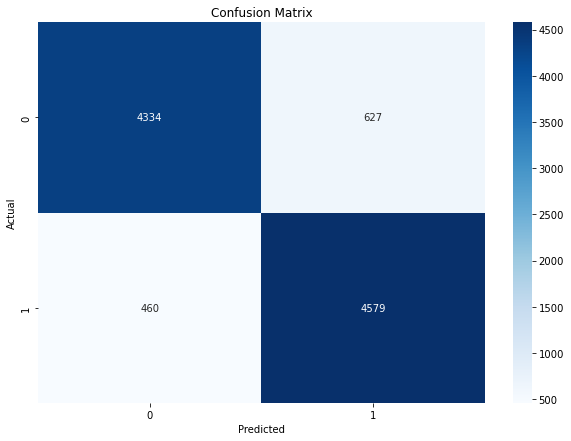

In [9]:

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')  # Save the plot as an image


In [10]:

# Connect to the new database
database = 'SentimentAnalysisDB'
connection_string = f'DRIVER={{SQL Server}};SERVER=HP\MSSQLSERVER01;DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()

# Create Table
cursor.execute('''
    IF OBJECT_ID('SentimentAnalysisResults', 'U') IS NULL
    CREATE TABLE SentimentAnalysisResults (
        id INT IDENTITY(1,1) PRIMARY KEY,
        review NVARCHAR(MAX),
        sentiment INT,
        predicted INT
    );
''')
conn.commit()

# Create a copy of the test data
test_data = pd.DataFrame(X_test.todense(), columns=vectorizer.get_feature_names_out())
test_data['sentiment'] = y_test.values
test_data['predicted'] = y_pred

# Insert the data into the SQL Server table
for index, row in test_data.iterrows():
    review_text = ' '.join(row.index[row != 0])
    cursor.execute('''
        INSERT INTO SentimentAnalysisResults (
            review, sentiment, predicted
        ) VALUES (?, ?, ?)
        ''',
        review_text, row['sentiment'], row['predicted']
    )
conn.commit()
conn.close()
